## Imports and setup

In [ ]:

# ---------------------------- Imports ---------------------------------
import os
import sys
import time
import numpy as np
import pandas as pd

# Include local module path
sys.path.append('/Users/nassirmohammad/projects/clustering')
# test comment for git

In [79]:
# Data generation utilities
from data.synthetic.one_dim_data import generate_clustering_1d_data
from data.synthetic.one_dim_data_gauss import generate_clustering_1d_gauss_anomalies
from data.synthetic.two_dim_data_gauss import generate_clustering_2d_gauss_data

# clustering method 
from clustering_methods import novel_clustering, seeded_k_means_clustering, kmeans_clustering, dbscan_clustering

# Plotting tools
from utilities.plotting import plot_clusters

## Generate synthetic data or read in data with a tiny amount of labelled data

Number of unlabelled examples: 29998
Number of labelled examples: 30
Percentage of labelled data: 0.1%


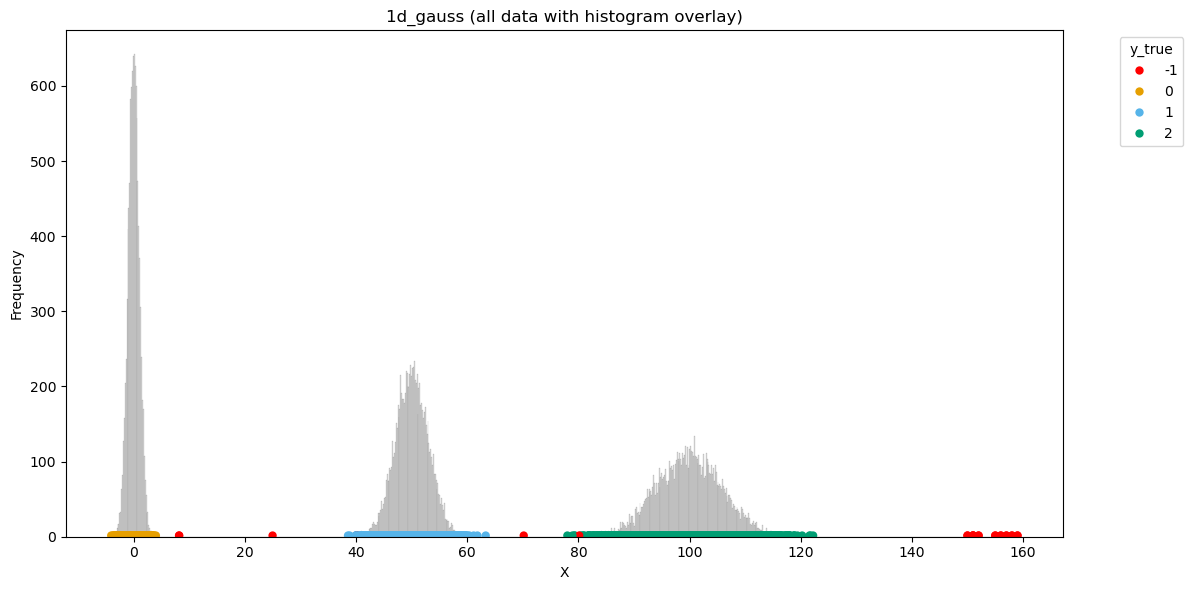

In [80]:
# ---------------------------- Data Setup ---------------------------------

# Define dataset mode
mode = "1d_gauss"  # Options: "1d_simple", "1d_gauss", "2d_gauss"
k = None  # Number of clusters (used by some algorithms like k-means, we supply ground truth number)

# Load selected dataset and plot
if mode == "1d_simple":
    k = 3
    df = generate_clustering_1d_data(repeat_const=100, percent_labelled=0.03, random_state=None)

elif mode == "1d_gauss":
    k = 3
    df = generate_clustering_1d_gauss_anomalies(random_seed=42,
                                               labelled_percent=0.1,
                                               cluster_params=[(0, 1), (50, 3), (100, 6)],
                                               samples_per_cluster=10000,
                                               include_anomaly_cluster=True,
                                               )

elif mode == "2d_gauss":
    k=5
    df = generate_clustering_2d_gauss_data(n_samples=10000,
                                        n_components=k,
                                        num_features=2,
                                        rand_seed=0,
                                        same_density=False,
                                        labelled_fraction=0.01,
                                        add_anomaly_cluster=True,
                                        plot=True,
                                        )

# Extract feature columns from the DataFrame
feature_columns = [col for col in df.columns if col not in {'y_true', 'y_live'}]

# assign the dataset name
dataset_name = mode

plot_clusters(df, feature_columns, label_column='y_true', title=dataset_name + ' (all data with histogram overlay)', show_seeds_only=False);

In [81]:
df

,X,y_true,y_live
0,96.414204,2,-1
1,51.848964,1,-1
2,53.169931,1,-1
3,92.841919,2,-1
4,96.619946,2,-1
...,...,...,...
30023,156.000000,-1,-1
30024,157.000000,-1,-1
30025,158.000000,-1,-1
30026,159.000000,-1,-1


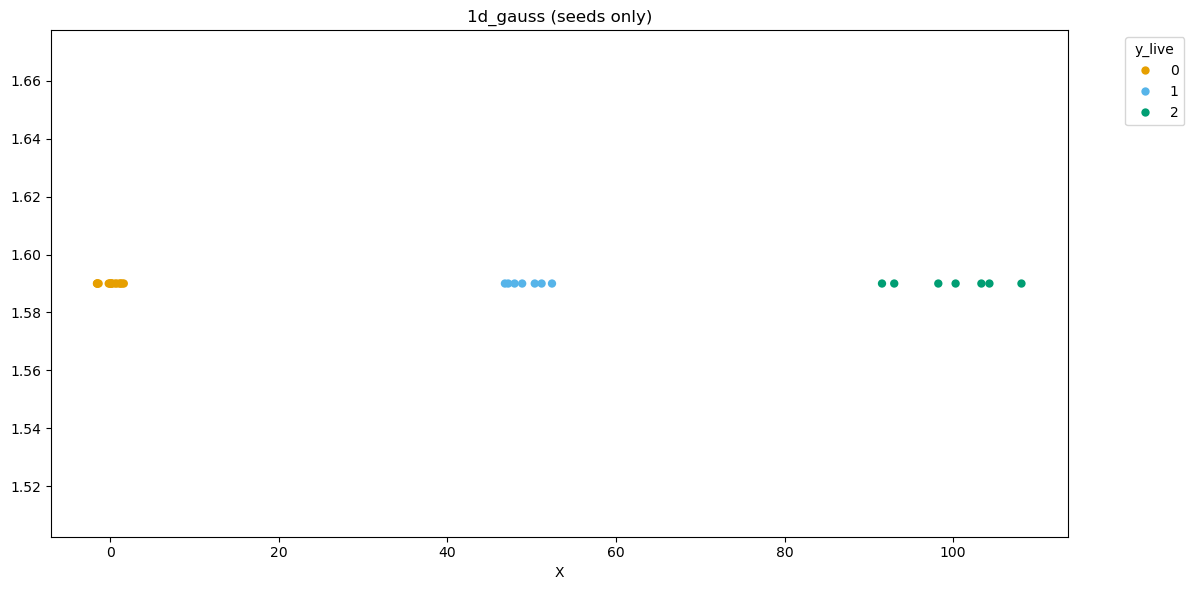

In [82]:
plot_clusters(df, feature_columns, label_column='y_live', title=dataset_name + ' (seeds only)', show_seeds_only=True)

## Run novel clustering method

In [83]:
# run the novel clustering algorithm
# ensure dataframe has 'y_live' column of partially labelled data for semi-supervised clustering
df_c = df.copy()
df_novel = novel_clustering(df_c, feature_columns, seeds='y_live')

1
2
3
4
5
6
7
8
9
10
11
12
13


In [84]:
df_novel

,X,y_true,y_live,novel_method
0,96.414204,2,-1,2
1,51.848964,1,-1,1
2,53.169931,1,-1,1
3,92.841919,2,-1,2
4,96.619946,2,-1,2
...,...,...,...,...
30023,156.000000,-1,-1,-1
30024,157.000000,-1,-1,-1
30025,158.000000,-1,-1,-1
30026,159.000000,-1,-1,-1


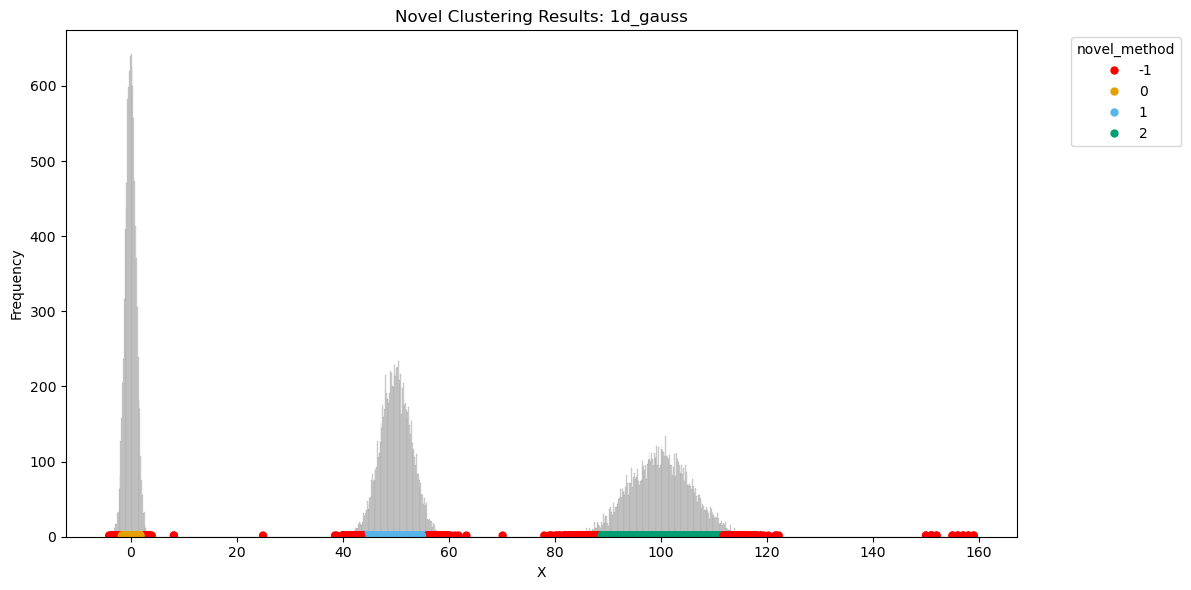

In [85]:
plot_clusters(df_novel, feature_columns, label_column='novel_method', title="Novel Clustering Results: " + dataset_name, show_seeds_only=False);

## Seeded k-means method

                X  y_true  y_live  SeededKMeans
0       96.414204       2      -1             2
1       51.848964       1      -1             1
2       53.169931       1      -1             1
3       92.841919       2      -1             2
4       96.619946       2      -1             2
...           ...     ...     ...           ...
30023  156.000000      -1      -1             2
30024  157.000000      -1      -1             2
30025  158.000000      -1      -1             2
30026  159.000000      -1      -1             2
30027  151.000000      -1      -1             2

[30028 rows x 4 columns]


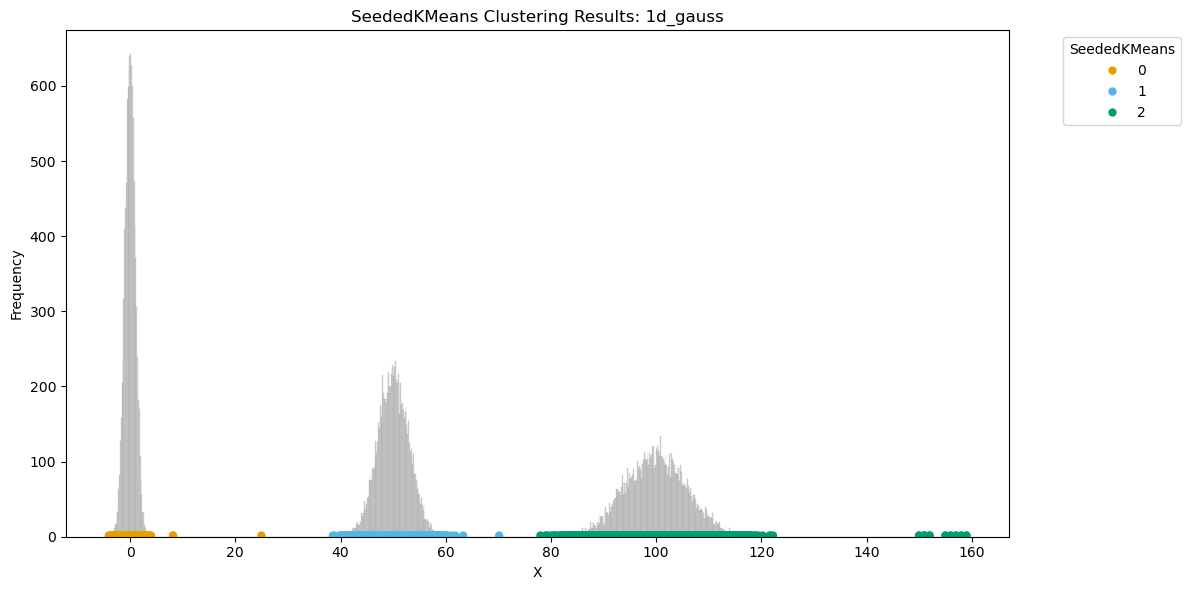

In [86]:
df_c = df.copy()
df_seeded_k_means = seeded_k_means_clustering(df_c, feature_columns, target_column='y_true', seeds='y_live', n_clusters=3, random_state=0, remap_labels=False)
print(df_seeded_k_means)
plot_clusters(df_seeded_k_means, feature_columns, label_column='SeededKMeans', title="SeededKMeans Clustering Results: " + dataset_name, show_seeds_only=False)

## K-means clustering method

                X  y_true  y_live  KMeans
0       96.414204       2      -1       2
1       51.848964       1      -1       1
2       53.169931       1      -1       1
3       92.841919       2      -1       2
4       96.619946       2      -1       2
...           ...     ...     ...     ...
30023  156.000000      -1      -1       2
30024  157.000000      -1      -1       2
30025  158.000000      -1      -1       2
30026  159.000000      -1      -1       2
30027  151.000000      -1      -1       2

[30028 rows x 4 columns]


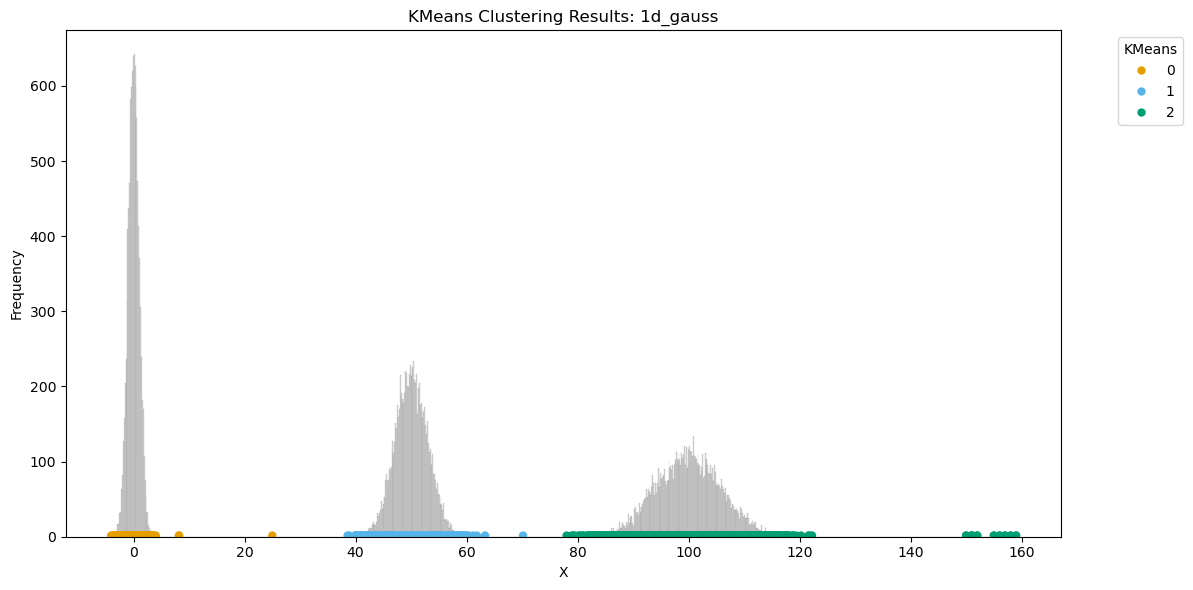

In [87]:
df_c = df.copy()
df_k_means = kmeans_clustering(df_c, feature_columns, target_column='y_true', n_clusters=3, random_state=0, remap_labels=False)
print(df_k_means)
plot_clusters(df_k_means, feature_columns, label_column='KMeans', title="KMeans Clustering Results: " + dataset_name, show_seeds_only=False)

## DBSCAN clustering method

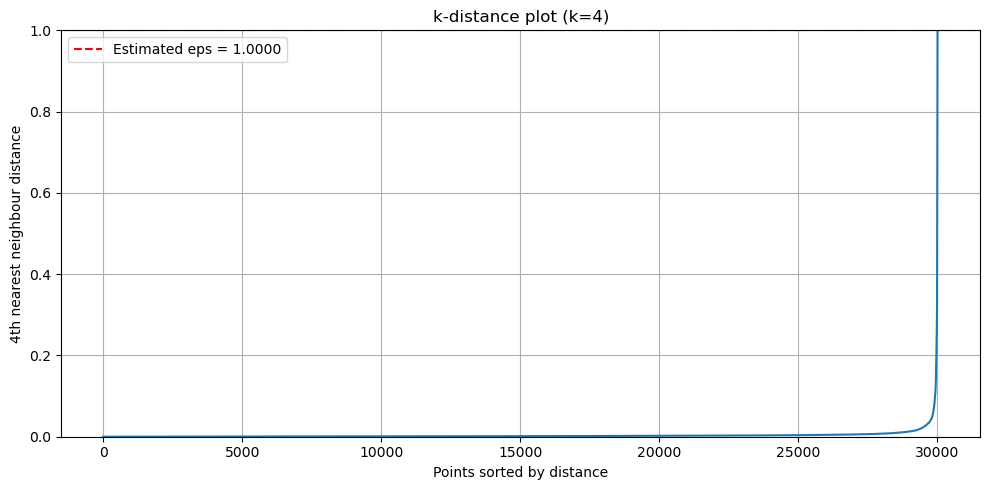

Estimated eps: 1.0


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def estimate_eps(df, feature_columns, k=5, zoom_ymax=2.0, detect_knee=True):
    """
    Estimate a good eps value for DBSCAN using the k-distance method.

    Parameters:
    - df: DataFrame containing your data.
    - feature_columns: list of feature column names (1D or 2D).
    - k: number of neighbours (min_samples = k).
    - zoom_ymax: max Y limit to zoom into the k-distance plot.
    - detect_knee: whether to automatically find the elbow point.

    Returns:
    - eps: Estimated eps value.
    """

    X = df[feature_columns].values

    # Fit NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)

    # Sort the k-th distance (k-1 index since indexing starts at 0)
    k_distances = np.sort(distances[:, k - 1])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(k_distances)
    plt.ylim(0, zoom_ymax)
    plt.title(f'k-distance plot (k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}th nearest neighbour distance')

    eps = None
    if detect_knee:
        knee_locator = KneeLocator(
            range(len(k_distances)),
            k_distances,
            curve='convex',
            direction='increasing'
        )
        eps = k_distances[knee_locator.knee] if knee_locator.knee is not None else None
        if eps:
            plt.axhline(y=eps, color='red', linestyle='--', label=f"Estimated eps = {eps:.4f}")
            plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return eps

eps = estimate_eps(df, feature_columns=['X'], k=4, zoom_ymax=1.0, detect_knee=True)
print(f"Estimated eps: {eps}")


                X  y_true  y_live  DBSCAN
0       96.414204       2      -1       0
1       51.848964       1      -1       1
2       53.169931       1      -1       1
3       92.841919       2      -1       0
4       96.619946       2      -1       0
...           ...     ...     ...     ...
30023  156.000000      -1      -1      -1
30024  157.000000      -1      -1      -1
30025  158.000000      -1      -1      -1
30026  159.000000      -1      -1      -1
30027  151.000000      -1      -1      19

[30028 rows x 4 columns]


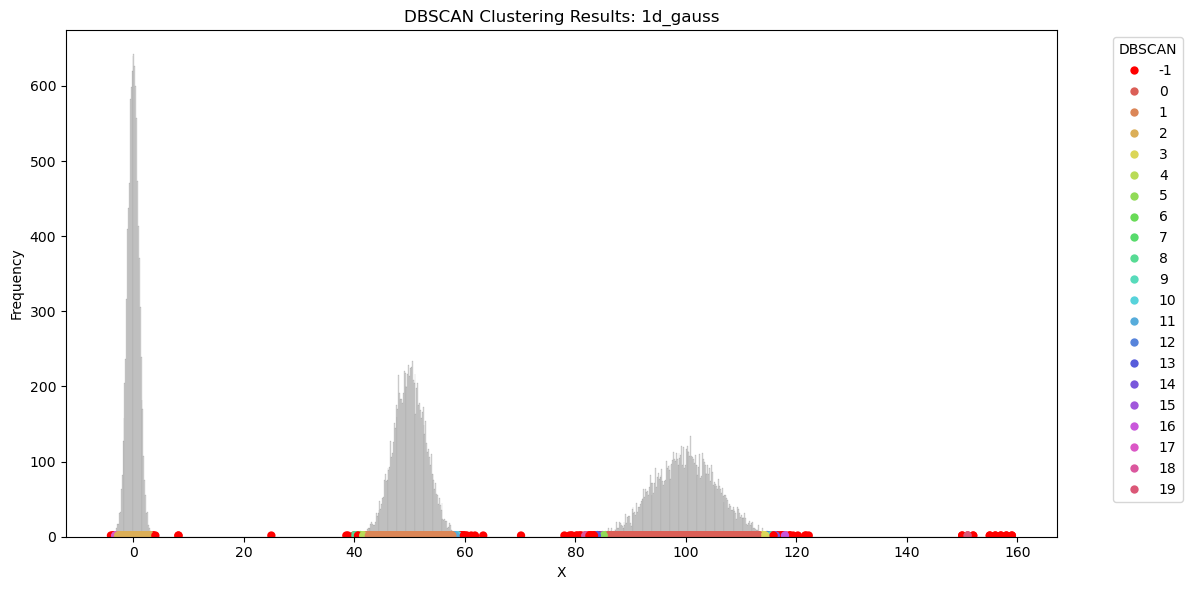

In [89]:
# eps selected as according to paper visually to be 0.1
# knee locator suggests 1
# min_samples = number_of_dimensions + 1 = 4
# sensitive to parameters eps and min_samples
df_c = df.copy()
df_dbscan = dbscan_clustering(df_c, feature_columns, target_column='y_true', eps=0.1, min_samples=4, remap_labels=False)
print(df_dbscan)
plot_clusters(df_dbscan, feature_columns, label_column='DBSCAN', title="DBSCAN Clustering Results: " + dataset_name, show_seeds_only=False)